### Cab-Driver Agent  DQN Architecute-1

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


### 1. Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Let's check the max, min and mean time values. 

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by 1 day.

### 2. Agent Class

we need to fill the following to complete  code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked =  []
        self.states_tracked_1 = []
        self.states_tracked_2 = []
        
        # We are going to track state [3,5,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([3,5,0])).reshape(1, 36)
        
        # We are going to track state [3,7,0] and action (0,3) at index 3 in the action space.
        self.track_state_1 = np.array(env.state_encod_arch1([3,7,0])).reshape(1, 36)
        
        # We are going to track state [3,6,0] and action (0,4) at index 4 in the action space.
        self.track_state_2 = np.array(env.state_encod_arch1([3,6,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that the driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            #print(state)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_tracking_states_1(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state_1)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value[0][3])
        
    def save_tracking_states_2(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state_2)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_2.append(q_value[0][4])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### 3. DQN block

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
Episode = 15000
#Episode = 100
m = 5  # number of location
t = 24 # number of hours per day
d = 7  # number of day per week

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
#### The init state is randomly picked from the state space for each episode.

In [6]:
start_time = time.time()
score_tracked = []

for episode in range(Episode):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices)
               
        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
            total_time = total_time - step_time
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode : {0}, reward : {1},  epsilon : {2},  total_time:{3}".format(episode,
                                                                         score,
                                                                         agent.epsilon, 
                                                                         total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
        agent.save_tracking_states_1()
        agent.save_tracking_states_2()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)



Saving Model 0
episode : 9, reward : -66.0,  epsilon : 0.9955001547284723,  total_time:717.0
episode : 19, reward : -170.0,  epsilon : 0.9905350769930761,  total_time:718.0
episode : 29, reward : -185.0,  epsilon : 0.9855947626861951,  total_time:712.0
episode : 39, reward : -26.0,  epsilon : 0.9806790882997144,  total_time:718.0
episode : 49, reward : 71.0,  epsilon : 0.9757879309415182,  total_time:713.0
episode : 59, reward : -297.0,  epsilon : 0.9709211683324178,  total_time:711.0
episode : 69, reward : -20.0,  epsilon : 0.9660786788030947,  total_time:715.0
episode : 79, reward : -278.0,  epsilon : 0.9612603412910584,  total_time:718.0
episode : 89, reward : -52.0,  epsilon : 0.9564660353376199,  total_time:716.0
episode : 99, reward : -438.0,  epsilon : 0.9516956410848808,  total_time:714.0
episode : 109, reward : -350.0,  epsilon : 0.9469490392727365,  total_time:718.0
episode : 119, reward : 55.0,  epsilon : 0.9422261112358942,  total_time:718.0
episode : 129, reward : -268.0,

### The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720



In [7]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [8]:
agent.states_tracked

[149.51736,
 138.11899,
 164.79251,
 262.99557,
 325.44165,
 327.8912,
 357.9482,
 385.72287,
 423.80435,
 404.63037,
 414.314,
 373.68857,
 355.7028,
 369.9942,
 367.61298,
 396.12378,
 359.6505,
 430.61795,
 418.73724,
 384.37634,
 426.24796,
 425.93274,
 420.88742,
 400.71722,
 450.61874,
 438.21457,
 422.76355,
 387.11087,
 354.79196,
 353.72107,
 345.46143,
 378.6163,
 389.37198,
 430.07477,
 397.91608,
 472.80432,
 437.51675,
 475.34576,
 447.4624,
 435.68796,
 495.18555,
 455.38452,
 418.00525,
 414.206,
 428.80753,
 402.90524,
 440.9854,
 466.2101,
 483.314,
 450.2056,
 455.0228,
 446.82095,
 419.30408,
 440.4279,
 433.34607,
 453.31567,
 427.29462,
 427.07367,
 446.265,
 501.91525,
 513.0647,
 486.60834,
 478.69153,
 405.1809,
 441.9476,
 416.1098,
 468.33154,
 467.82855,
 499.94565,
 499.68317,
 471.88284,
 462.63477,
 428.02438,
 445.95197,
 434.66782,
 484.7917,
 479.53864,
 461.93304,
 489.29102,
 490.98273,
 451.8264,
 466.201,
 447.64432,
 443.67972,
 472.4191,
 504.6393

In [9]:
agent.states_tracked_1

[140.25691,
 114.64695,
 146.96695,
 253.6216,
 299.83948,
 321.14447,
 338.76633,
 359.20663,
 403.30746,
 386.2706,
 408.0611,
 360.28238,
 347.6237,
 360.73898,
 360.55243,
 364.55573,
 337.98874,
 400.68774,
 395.19952,
 360.64792,
 396.5447,
 398.9566,
 390.7498,
 386.935,
 440.89078,
 426.72363,
 407.1877,
 373.42496,
 344.88034,
 346.2225,
 337.88025,
 368.85754,
 372.18823,
 407.7153,
 380.61966,
 455.55984,
 421.98596,
 455.09082,
 448.67297,
 419.76193,
 482.33948,
 427.18143,
 401.0373,
 401.0457,
 423.85184,
 392.08957,
 419.72272,
 459.5073,
 458.8484,
 432.0829,
 430.80615,
 423.2547,
 394.40146,
 419.9391,
 410.91855,
 428.08505,
 412.94217,
 410.88565,
 420.10745,
 468.73834,
 481.52515,
 468.6105,
 453.94974,
 383.32025,
 419.73953,
 398.20694,
 438.15833,
 454.09146,
 478.36075,
 477.27835,
 454.0358,
 444.76566,
 414.36884,
 432.3488,
 415.0363,
 468.8765,
 459.74435,
 441.72568,
 467.03036,
 485.4596,
 441.03442,
 461.39847,
 427.5736,
 436.4297,
 459.62067,
 490.18

In [10]:
agent.states_tracked_2

[134.0051,
 112.96812,
 144.16579,
 247.27718,
 300.27475,
 309.58127,
 344.82602,
 360.4231,
 403.81808,
 390.86508,
 401.38336,
 360.4728,
 333.16998,
 347.1558,
 334.957,
 361.01538,
 333.0074,
 403.26166,
 392.84238,
 354.9609,
 396.1215,
 394.02206,
 399.8174,
 381.95264,
 434.03513,
 415.65488,
 399.51242,
 371.31516,
 347.33084,
 339.99902,
 331.06586,
 364.80026,
 364.48553,
 409.41638,
 381.1141,
 456.9147,
 407.3232,
 447.0007,
 430.09152,
 415.0907,
 478.6253,
 439.30212,
 398.90753,
 392.82007,
 413.2766,
 391.01642,
 422.8196,
 452.00394,
 459.20447,
 437.5543,
 435.84024,
 431.96823,
 395.01678,
 420.30136,
 420.11438,
 434.93228,
 412.6043,
 419.73138,
 419.74295,
 475.59534,
 481.02948,
 474.70242,
 469.3068,
 396.83316,
 429.065,
 402.372,
 436.39935,
 446.5979,
 476.28827,
 475.39554,
 447.608,
 443.9057,
 413.94452,
 431.00375,
 415.60864,
 475.89822,
 461.7136,
 444.93243,
 466.59027,
 479.08752,
 436.07498,
 452.20273,
 428.4732,
 436.0804,
 460.2733,
 488.74814,
 

### 5. Plot the Q-Value convergence for state action pairs

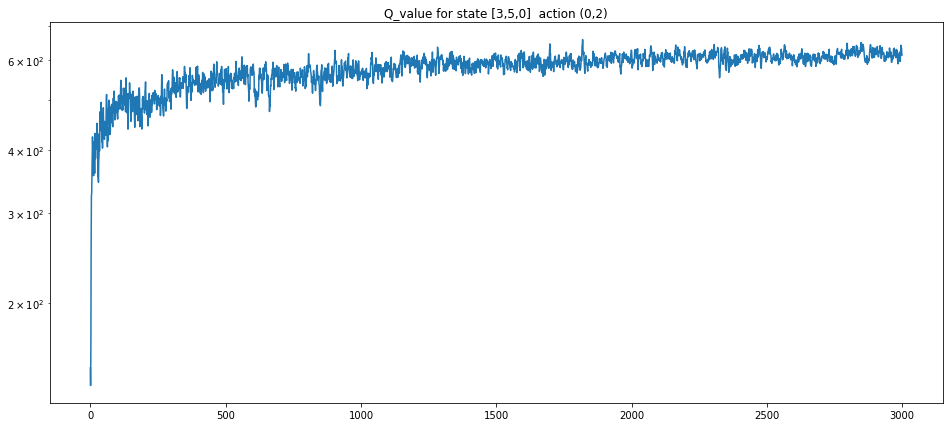

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [3,5,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### We are using log scale because the initial q_values are way to high compared to the steady state value (around 600)

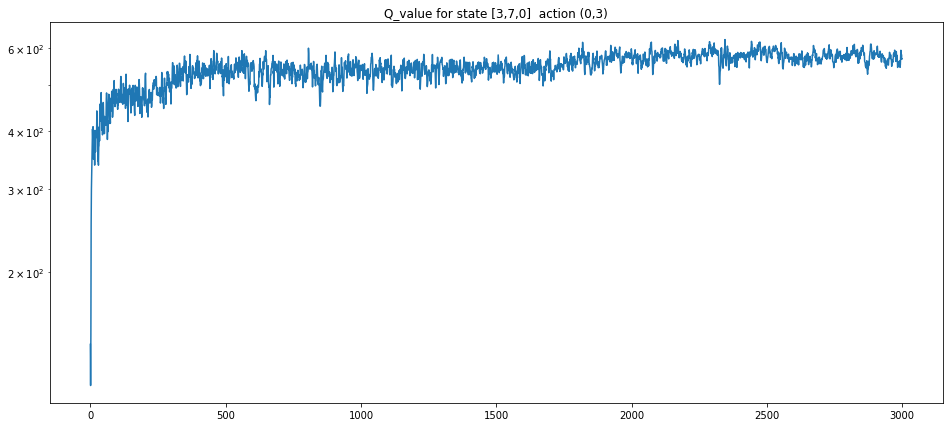

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [3,7,0]  action (0,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked_1)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked_1))
plt.show()

#### We are using log scale because the initial q_values are way to high compared to the steady state value (around 600)

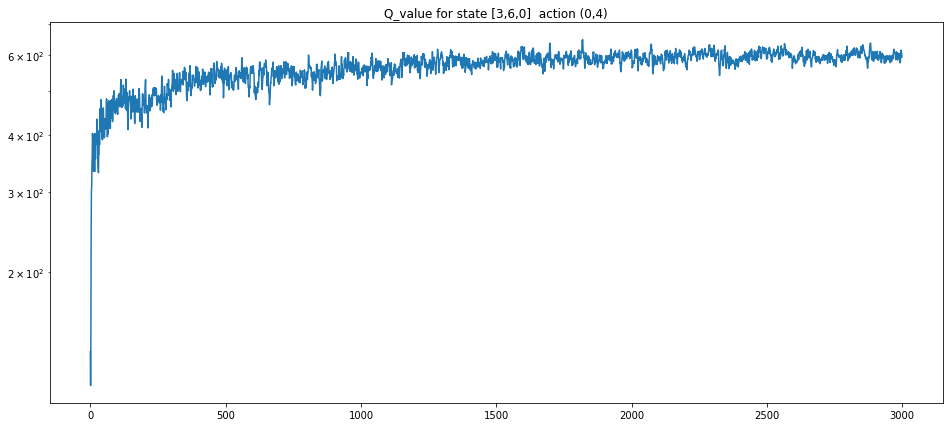

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [3,6,0]  action (0,4)')
xaxis = np.asarray(range(0, len(agent.states_tracked_2)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked_2))
plt.show()

### 6. Track rewards per episode.

In [14]:
print(" MAXimum Reward = {}".format(max(score_tracked)))
avg = sum(score_tracked)/len(score_tracked)
print ("AVerage Reward = {}".format(avg))

 MAXimum Reward = 2187.0
AVerage Reward = 1381.2413333333334


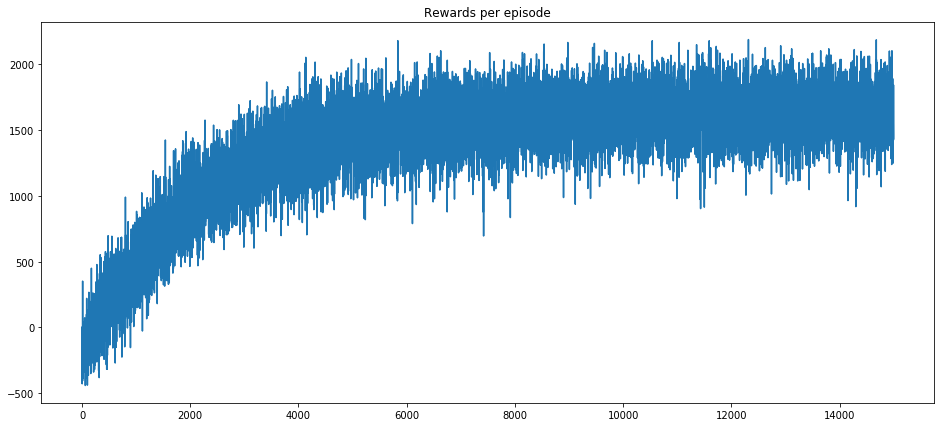

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.show()

### We can see from the above plot that the rewards converge at around 2000. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

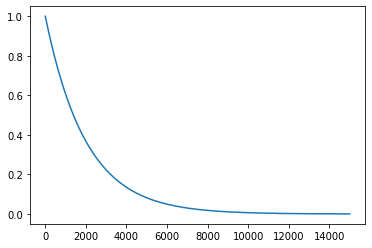

In [17]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()